##**Are there disparities in police award nominations?** 
This notebook analyzes the racial disparities in award nominations in Chicago Police Departments using graph analytics.


**Intsructions:**

1. Before running the cell, first download the graphframes jar file from: [Graphframe jar file.](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

  Upload it in the Google Colab Files folder. Can be found in the left pane of this window.
2. Upload the "policerace.xlsx."
3. ProTip: You can change the Runtime type to GPU to speed the running time.

# **Spark and Graphframe set up**

In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 198 kB 36.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=81729521c7a56e3d331bb3ac7140996615854de8b2f6bedf4d2611e93bb2939e
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
     |████████████████████████████████| 154 kB 6.7 MB/s 


In [ ]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [ ]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd
import psycopg2
import numpy as np
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# **Generate the SQL query from Postgresql**

In [ ]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")
cursor = conn.cursor()

In [ ]:
query = "select\
       unit_description as District_Number_Name,\
       dof_id as officer_id,\
       dof_first_name as officer_first_name,\
       dof_last_name as officer_last_name,\
       dof_race as officer_race,\
       dof_rank as officer_rank\
 from (\
    select\
           dof.id as dof_id,\
           dof.last_name as dof_last_name,\
           dof.first_name as dof_first_name,\
           dof.race as dof_race,\
           dof.rank as dof_rank,\
 area_beat.unit_description\
    from data_officer as dof join (\
        select\
               *, da.id as da_id, dpb.id as dpb_id, area_id as da_area_id\
        from\
             data_policebeat as dpb\
                 join data_area da\
                     on dpb.area_id = da.id) as area_beat\
        on dof.last_unit_id = area_beat.unit_id\
    where unit_description in ('22ND DISTRICT - MORGAN PARK','16TH DISTRICT - JEFFERSON PARK','5TH DISTRICT - CALUMET','2ND DISTRICT - WENTWORTH','6TH DISTRICT - GRESHAM','12TH DISTRICT - NEAR WEST')\
    group by dof_id, unit_description, major_award_count) as officer_unitdesc_award"
  
cursor.execute(query)

officer_data = cursor.fetchall()
df_officer_data = pd.DataFrame(officer_data)
colnames = [desc[0] for desc in cursor.description]
df_officer_data.columns = colnames

query = "select officer_id,requester_full_name from data_award"
cursor.execute(query)

req_name = cursor.fetchall()
df_req_name = pd.DataFrame(req_name)
colnames = [desc[0] for desc in cursor.description]
df_req_name.columns = colnames

#**Police Department Population By Race Analysis**

In [ ]:
policerace = pd.read_excel('policerace.xlsx')

In [ ]:
policerace['majority'] = ' '

In [ ]:
for i in policerace['District_Number_Name'].unique():
  percent_max = (policerace['Percentage'][policerace['District_Number_Name'] == i]).max()
  print(percent_max)
  index = policerace.index
  condition = policerace["District_Number_Name"] == i
  district_indices = index[condition]

  district_indices_list = district_indices.tolist()
  print(district_indices_list)
  for j in district_indices_list:
    policerace['majority'][j] = policerace['Race'][(policerace['Percentage'] == percent_max)].values[0]

In [ ]:
policerace['Race'][(policerace['Percentage'] == percent_max)].values[0]

'White'

In [ ]:
policerace

,District_Number_Name,Race,No_of_Officers,Total/District,Percentage,majority
0,10TH DISTRICT - OGDEN,Hispanic,200,357,0.560224,Hispanic
1,10TH DISTRICT - OGDEN,White,125,357,0.350140,Hispanic
2,10TH DISTRICT - OGDEN,Black,23,357,0.064426,Hispanic
3,10TH DISTRICT - OGDEN,Asian/Pacific,9,357,0.025210,Hispanic
4,11TH DISTRICT - HARRISON,White,212,387,0.547804,White
...,...,...,...,...,...,...
97,8TH DISTRICT - CHICAGO LAWN,Native American/Alaskan Native,1,388,0.002577,White
98,9TH DISTRICT - DEERING,White,208,360,0.577778,White
99,9TH DISTRICT - DEERING,Hispanic,112,360,0.311111,White
100,9TH DISTRICT - DEERING,Black,26,360,0.072222,White


# **Data Processing**

In [ ]:
df_officer_data['full_name'] = df_officer_data['officer_first_name']+' '+df_officer_data['officer_last_name']
req_officer = df_req_name.groupby(['requester_full_name','officer_id']).size()
req_officer = req_officer.reset_index()
req_officer = req_officer.rename(columns={'0':'award_counts'})

def get_id(name):
  if name in df_officer_data['full_name'].values:
    return df_officer_data['officer_id'][df_officer_data['full_name']==name].values[0]
    return np.nan

def get_race(name):
  if name in df_officer_data['full_name'].values:
    return df_officer_data['officer_race'][df_officer_data['full_name']==name].values[0]
  else:
    return np.nan

def get_officer_race(id):
  if id in df_officer_data['officer_id'].values:
    return df_officer_data['officer_race'][df_officer_data['officer_id']==id].values[0]
  else:
    return np.nan
def get_district(id):
  if id in df_officer_data['officer_id'].values:
    return df_officer_data['district_number_name'][df_officer_data['officer_id']==id].values[0]
  else:
    return np.nan
req_officer = req_officer[req_officer['requester_full_name']!='  ']
req_officer = req_officer.reset_index()
req_officer['requester_full_name'] = req_officer['requester_full_name'].str.replace(" ","")
df_officer_data['full_name']=df_officer_data['full_name'].str.replace(" ","")
req_officer['requester_id'] = req_officer['requester_full_name'].apply(lambda x: get_id(x) )
req_officer['requester_race'] = req_officer['requester_full_name'].apply(lambda x: get_race(x) )
req_officer['officer_race'] = req_officer['officer_id'].apply(lambda x: get_officer_race(x) )
req_officer['district'] = req_officer['officer_id'].apply(lambda x: get_district(x) )

req_officer.columns = req_officer.columns.astype(str) 

data = req_officer[-req_officer['requester_id'].isna()]
data = data[-data['requester_race'].isna()]
data = data[-data['officer_race'].isna()]
data = data.drop(['index'],axis=1)
data = data.reset_index(drop = True)

# **Generating vertices and edges**

In [ ]:
vertex1 = data[['requester_id', 'requester_full_name', '0']]
vertex1 = vertex1.groupby(['requester_id','requester_full_name'])['0'].sum().reset_index()
vertex1.rename({'requester_id': 'id', 'requester_full_name': 'requester_full_name', '0' : 'award_count'}, axis=1, inplace=True)

edge1 = data[['officer_id', 'requester_id', '0','requester_race','officer_race','district']]

#edge1 = data[['officer_id', 'requester_id', '0']]
edge1.rename({'officer_id': 'src', 'requester_id': 'dst', '0' : "relationship"}, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#create a spark dataframe and generate graphfarme with its vertices and edges
edges1 = spark.createDataFrame(edge1)
verticies1 = spark.createDataFrame(vertex1)
rq = GraphFrame(verticies1, edges1)

In [ ]:
#vertices table
rq.vertices.sort(['award_count'],ascending=False).show()

+-------+-------------------+-----------+
|     id|requester_full_name|award_count|
+-------+-------------------+-----------+
|15728.0|       RobertLarson|       1287|
|25976.0|       KevinSellers|       1131|
|24849.0|         DavidRucci|       1072|
|30907.0|       MargitWillis|        767|
| 9963.0|   GregoryGilfillan|        635|
| 6736.0|      ArshellDennis|        608|
|19163.0|       KeithMilmine|        595|
|18702.0|       VictorMedina|        589|
|26777.0|       TimothySmith|        579|
| 1072.0|   HootanBahmandeji|        575|
|21710.0|       PhilipPaluch|        572|
|31199.0|        RobertWoods|        565|
|16733.0|           JoseLule|        561|
| 5063.0|    TerrenceCollins|        559|
|11152.0|       PaulHagemann|        540|
|26641.0|      GregorySloyan|        529|
|25799.0|      AnthonySchulz|        524|
|12195.0|    ReginaHightower|        516|
|19351.0|       JosephMolina|        472|
|23979.0|       ThereseRiley|        458|
+-------+-------------------+-----

In [ ]:
#transform the graph to dataframe
rq_p = rq.vertices.toPandas()

In [ ]:
#top award requesters based on the award_count
top_20rq = rq_p.sort_values(by='award_count', ascending=False).head(20)

In [ ]:
top_20rq.rename(columns={"id": "requester_id", "requester_full_name": "requester_full_name", 'award_count' : 'award_count'})

,id,requester_full_name,award_count
178,15728.0,RobertLarson,1287
322,25976.0,KevinSellers,1131
303,24849.0,DavidRucci,1072
378,30907.0,MargitWillis,767
103,9963.0,GregoryGilfillan,635
71,6736.0,ArshellDennis,608
227,19163.0,KeithMilmine,595
222,18702.0,VictorMedina,589
333,26777.0,TimothySmith,579
9,1072.0,HootanBahmandeji,575


In [ ]:
top_20 = data[data['requester_id'].isin(top_20rq)].groupby(['district','requester_id','requester_full_name','requester_race','officer_race'])['0'].sum().reset_index()

**Further analysis of the top 20 award requesters**

In [ ]:
data['district'][data['requester_full_name'] == 'GregoryGilfillan'].value_counts()

16TH DISTRICT - JEFFERSON PARK    583
12TH DISTRICT - NEAR WEST           3
2ND DISTRICT - WENTWORTH            1
5TH DISTRICT - CALUMET              1
Name: district, dtype: int64

In [ ]:
data['officer_race'][data['requester_full_name'] == 'RobertLarson'].value_counts()

White                             387
Black                             156
Hispanic                           23
Asian/Pacific                       2
Native American/Alaskan Native      1
Name: officer_race, dtype: int64

In [ ]:
data['officer_race'][data['requester_full_name'] == 'ArshellDennis'].value_counts()

Black            314
White            172
Hispanic          74
Asian/Pacific      8
Name: officer_race, dtype: int64

In [ ]:
#edges grouped by the total award count
rq.edges.sort(['relationship'],ascending=False).show()

+-----+-------+------------+--------------+------------+--------------------+
|  src|    dst|relationship|requester_race|officer_race|            district|
+-----+-------+------------+--------------+------------+--------------------+
|21309|21309.0|         132|         White|       White|5TH DISTRICT - CA...|
|15728|15728.0|         104|         White|       White|22ND DISTRICT - M...|
| 2463|15728.0|          95|         White|       White|22ND DISTRICT - M...|
|25799|25799.0|          77|         White|       White|6TH DISTRICT - GR...|
|17351|15728.0|          70|         White|       White|22ND DISTRICT - M...|
| 7167|19163.0|          69|         White|       White|6TH DISTRICT - GR...|
|32383|18721.0|          63|      Hispanic|    Hispanic|6TH DISTRICT - GR...|
|  933|19855.0|          62|         Black|       Black|6TH DISTRICT - GR...|
|20053|25030.0|          62|         White|       White|12TH DISTRICT - N...|
| 2849|19163.0|          62|         White|       Black|6TH DIST

In [ ]:
edge1[edge1['src']==edge1['dst'].astype(int)].groupby(['district','requester_race'])['relationship'].sum()

district                        requester_race
12TH DISTRICT - NEAR WEST       Hispanic           24
                                White             327
16TH DISTRICT - JEFFERSON PARK  Asian/Pacific       1
                                Hispanic           19
                                White             364
22ND DISTRICT - MORGAN PARK     Black               4
                                Hispanic            5
                                White             242
2ND DISTRICT - WENTWORTH        Black              67
                                Hispanic            1
                                White               3
5TH DISTRICT - CALUMET          Asian/Pacific       1
                                Black              54
                                Hispanic           22
                                White             257
6TH DISTRICT - GRESHAM          Black              66
                                Hispanic            9
                                Whi

# **Checking indegrees and outdeegres of the network of the requesters and police officers**

**Indegrees** helps us to identify the number of edges directed into the vertex. With the sort function, we can find the vertices and nodes that are highly connected to each other in requested table.

In [ ]:
rq.inDegrees.sort(['inDegree'],ascending=[0]).show()

+-------+--------+
|     id|inDegree|
+-------+--------+
| 9963.0|     588|
| 1072.0|     573|
|15728.0|     569|
| 6736.0|     568|
|25976.0|     560|
|18702.0|     544|
|31199.0|     543|
|16733.0|     539|
|11152.0|     537|
|26777.0|     513|
|24849.0|     513|
| 5063.0|     506|
|12195.0|     505|
|21710.0|     494|
|26439.0|     437|
|19351.0|     428|
|13777.0|     414|
|22423.0|     388|
|21735.0|     383|
|30907.0|     174|
+-------+--------+
only showing top 20 rows



**OutDegrees** gives us the number of awards police officer receives 

In [ ]:
rq.outDegrees.sort(['outDegree'],ascending=[0]).show()

+-----+---------+
|   id|outDegree|
+-----+---------+
| 3549|       27|
| 2463|       23|
|20807|       23|
| 5544|       20|
|31737|       20|
| 2852|       19|
|25018|       19|
|19673|       19|
|21325|       19|
|15728|       19|
|10152|       19|
| 5343|       18|
| 8169|       18|
|  451|       18|
|20477|       18|
|30368|       18|
| 7311|       18|
| 2981|       18|
| 2849|       17|
|23195|       17|
+-----+---------+
only showing top 20 rows



# **Page Rank** 
**Page Rank** provides rought estimate about the importance of the node

In [ ]:
#graph PageRank algorithm
pr = rq.pageRank(resetProbability=0.15, tol=0.01)
pr.vertices.show()

+------+-------------------+-----------+-------------------+
|    id|requester_full_name|award_count|           pagerank|
+------+-------------------+-----------+-------------------+
|   1.0|       JefferyAaron|          1|0.18248491981102968|
| 130.0|     RichardAdamski|          3|0.18248491981102968|
| 157.0|        CheriAdrian|          8| 0.2508213325754687|
| 274.0|       JeromeAlbert|          5|0.18248491981102968|
| 323.0|   MichaelAlexander|         56| 1.3548722808891926|
| 640.0|     RobertAnderson|         72| 0.4494949795588922|
| 818.0|   RebeccaArguelles|          9|0.18248491981102968|
| 997.0|          JackAxium|         13|0.18248491981102968|
|1036.0|    ThomasBachelder|         53| 0.4864654520655116|
|1072.0|   HootanBahmandeji|        575| 12.418912317350967|
|1148.0|      TimothyBalasz|         34|0.20992784429030376|
|1184.0|           JohnBall|         47|  0.766806386652658|
|1219.0|PhilipBanaszkiewicz|         30| 0.2508213325754687|
|1354.0|       DennisBar

In [ ]:
#the most important requesters in the page rank 
pr.vertices.orderBy('pagerank', ascending=False).show()

+-------+-------------------+-----------+------------------+
|     id|requester_full_name|award_count|          pagerank|
+-------+-------------------+-----------+------------------+
|26777.0|       TimothySmith|        579|15.144915787282617|
| 9963.0|   GregoryGilfillan|        635|12.942366412288695|
| 1072.0|   HootanBahmandeji|        575|12.418912317350967|
|21710.0|       PhilipPaluch|        572|12.414940444783149|
|31717.0|         NicolaZodo|         45|10.139397396146219|
|15728.0|       RobertLarson|       1287| 9.641386836280889|
|25976.0|       KevinSellers|       1131| 8.059565819583874|
| 6736.0|      ArshellDennis|        608| 8.018470407099407|
|16154.0|       GenessaLewis|        166| 6.393041564682479|
|11152.0|       PaulHagemann|        540| 6.083238053906538|
|16733.0|           JoseLule|        561|  6.04796160647554|
|11380.0|       PatrickHaran|        278|6.0233792151753525|
|18702.0|       VictorMedina|        589| 5.952758413631607|
|16461.0|        Charles

In [ ]:
pr_pandas = pr.vertices.toPandas().sort_values('pagerank', ascending=False)

In [ ]:
#create sample table about the number of requester awards per requester race in selected six districts 
ids = pr_pandas['id'].values
req = data[data['requester_id'].isin(ids)].groupby(['district','requester_id','requester_race','officer_race'])['0'].sum().reset_index()
def get_majority(district):
  return policerace['majority'][policerace['District_Number_Name'] == district].values[0]

req['majority'] = req['district'].apply(lambda x : get_majority(x))

In [ ]:
df_req = req.groupby(['district','majority','requester_race'])['0'].sum().reset_index()
df_req = df_req.rename(columns={'0':'awards_requested_count'})

In [ ]:
#interactive visualization for page rank 
fig = px.box(pr_pandas, y="pagerank", notched=True, hover_data=["requester_full_name"], width=500, height=600)
fig.update_traces(boxpoints='all')
fig.update_traces(marker_color = 'lightseagreen')
fig.show()

In [ ]:
pr.edges.show()

+-----+-------+------------+--------------+------------+--------------------+-------------------+
|  src|    dst|relationship|requester_race|officer_race|            district|             weight|
+-----+-------+------------+--------------+------------+--------------------+-------------------+
| 4142|26920.0|           3|         White|       White|16TH DISTRICT - J...|0.16666666666666666|
| 4142|14939.0|           1|         White|       White|16TH DISTRICT - J...|0.16666666666666666|
| 4142|23388.0|           1|      Hispanic|       White|16TH DISTRICT - J...|0.16666666666666666|
| 4142|21564.0|           1|         White|       White|16TH DISTRICT - J...|0.16666666666666666|
| 4142| 1072.0|           1| Asian/Pacific|       White|16TH DISTRICT - J...|0.16666666666666666|
| 4142| 9963.0|           1|         White|       White|16TH DISTRICT - J...|0.16666666666666666|
|16561|16154.0|           1|         Black|    Hispanic|2ND DISTRICT - WE...|                1.0|
|12256| 7993.0|     

In [ ]:
pr_edges = pr.edges.toPandas()

In [ ]:
pr.edges.orderBy('weight', ascending=False).show()

+-----+-------+------------+--------------+-------------+--------------------+------+
|  src|    dst|relationship|requester_race| officer_race|            district|weight|
+-----+-------+------------+--------------+-------------+--------------------+------+
|12832|20819.0|           1|         White|        White|22ND DISTRICT - M...|   1.0|
|11970|11756.0|           1|         White|        White|6TH DISTRICT - GR...|   1.0|
| 6371|16154.0|           1|         Black|        Black|2ND DISTRICT - WE...|   1.0|
| 8274|16154.0|           1|         Black|        White|2ND DISTRICT - WE...|   1.0|
|13231|16154.0|           1|         Black|        Black|2ND DISTRICT - WE...|   1.0|
|16561|16154.0|           1|         Black|     Hispanic|2ND DISTRICT - WE...|   1.0|
|16163|30884.0|           2|         White|        Black|12TH DISTRICT - N...|   1.0|
| 6464|30907.0|           1|         White|        White|2ND DISTRICT - WE...|   1.0|
|13977|13977.0|          23|         White|        Whi

The edge table of the page rank describes the significance of the relationship between the source and destination. As stated in the introduction, source is the police officer who is nominated and destination is the award requested persona. 

***Visualize*** the networks of only 10 nodes. To analyze the more networks, increase the size of batch and node_size.

In [ ]:
batch = set(pr_pandas[:10]['id'])

In [ ]:
def plot_graph(pr_edges):
    plt.figure(figsize=(30,20))
    g = nx.Graph()
    g = nx.from_pandas_edgelist(pr_edges, 'src', 'dst')
    nx.draw(g, with_labels=True, arrows=True, node_color='grey', node_size=10)
    plt.show()
# plot_graph(pr_edges)

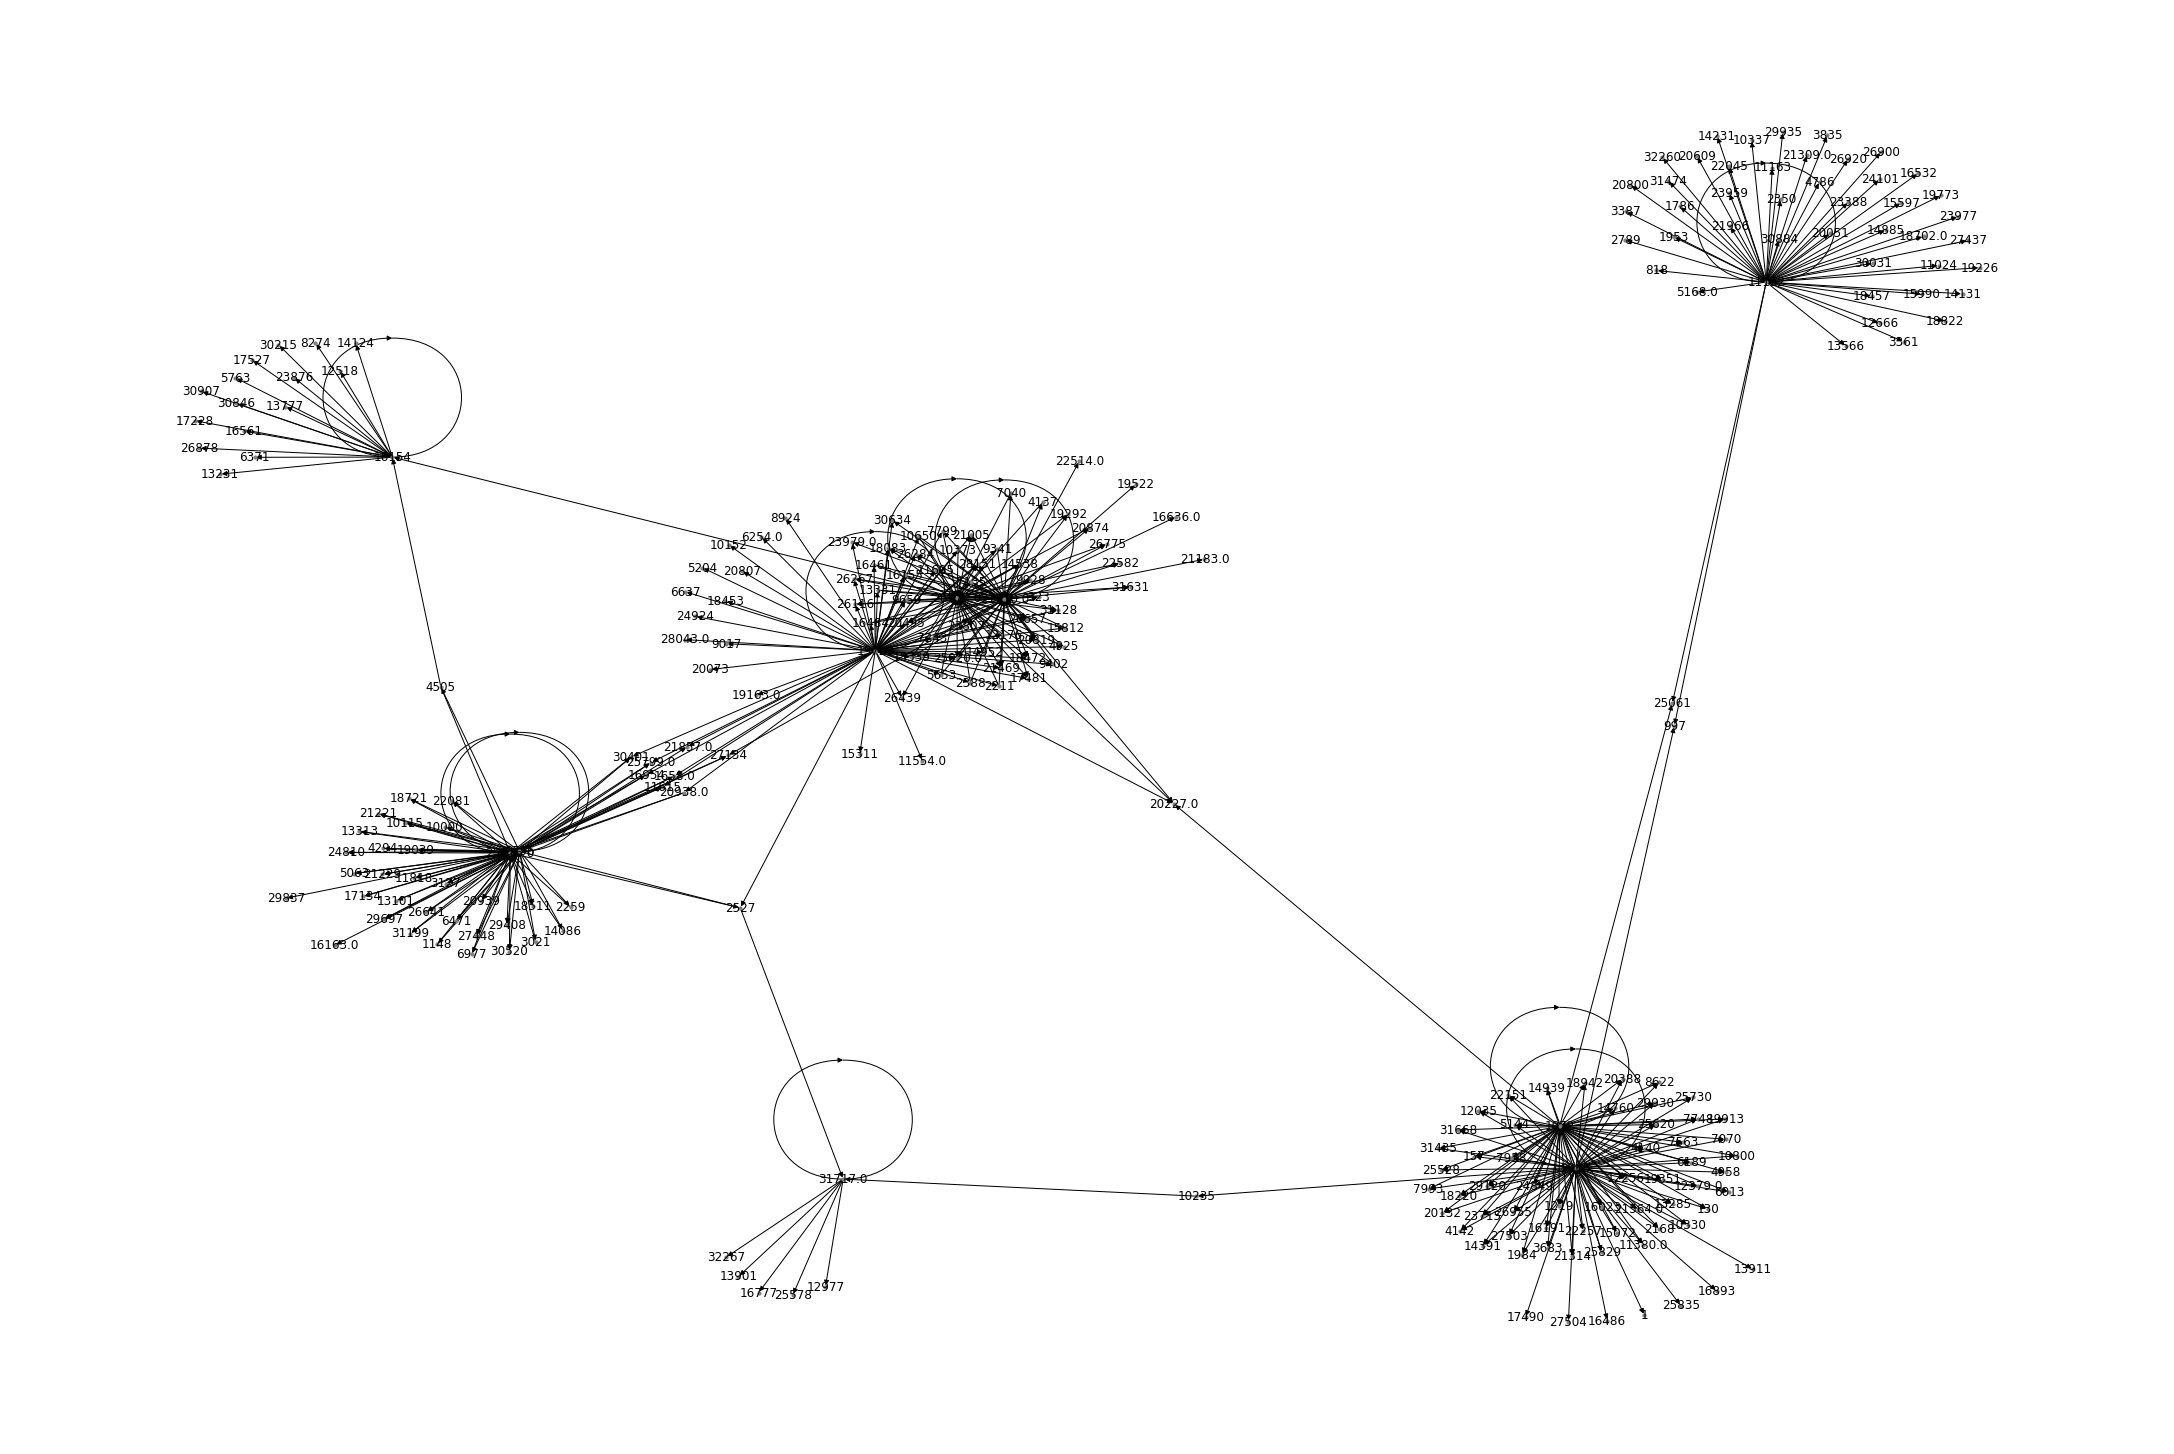

In [ ]:
plot_graph(pr_edges[(pr_edges['src'].isin(batch)) | (pr_edges['dst'].isin(batch))])

# **Aggregate Messages** 

How to quantify the connection between the award requesters and the number of awards? To understand the total number of awards appointed by neighbors of a particular requester , we used GraphX built-algorithm - Aggregate Messages which aggregates the messages from the neighboring edges and vertices of each vertex

In [ ]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM

In [ ]:
#calculate the aggregated awards across the edges 
msgToSrc = AM.dst["award_count"]
msgToDst = AM.src["award_count"]
agg = rq.aggregateMessages(
    sqlsum(AM.msg).alias("summedAwards"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['summedAwards'],ascending=False).show()

+-------+------------+
|     id|summedAwards|
+-------+------------+
|15728.0|       11843|
|21710.0|        9228|
| 6736.0|        8557|
|25799.0|        8210|
|25976.0|        7720|
|23979.0|        7659|
|31199.0|        7320|
|26777.0|        7170|
| 9963.0|        7144|
|19351.0|        7093|
| 2211.0|        7077|
|30401.0|        7012|
| 1072.0|        6890|
|16461.0|        6817|
|20495.0|        6457|
|16954.0|        6416|
|26439.0|        6213|
|20807.0|        6182|
|26641.0|        6117|
| 1658.0|        6074|
+-------+------------+
only showing top 20 rows



In [ ]:
#interactive visualization for aggregated awards
fig = px.box(agg.toPandas(), y="summedAwards", notched=True, hover_data=["id"], width=500, height=600)
fig.update_traces(boxpoints='all')
fig.update_traces(marker_color = 'indianred')
fig.show()

In [ ]:
ids20 = pr_pandas['id'][:20].values
data_top_20 = data[data['requester_id'].isin(ids20)].groupby(['district','requester_id','requester_race','officer_race'])['0'].sum().reset_index()

In [ ]:
data_top_20

# **Label Propagation**

In [ ]:
#find the grouped networ of the requesters 
communities = rq.labelPropagation(maxIter=40)
communities.orderBy('label', ascending=False).show()
print (f"There are {communities.select('label').distinct().count()} communities in this sample graph.")

+-------+-------------------+-----------+-------------+
|     id|requester_full_name|award_count|        label|
+-------+-------------------+-----------+-------------+
|    1.0|       JefferyAaron|          1|1683627180034|
|16893.0|       ColinMacniff|         15|1683627180034|
|23726.0|      RobertRentner|        162|1683627180034|
|25578.0|JosephSchachelmayer|        141|1683627180034|
|32267.0|      RobertPodkowa|         44|1675037245441|
|17477.0|         SeanMartin|          3|1649267441665|
|25700.0|        PaulSchmitz|         14|1623497637890|
|23491.0|        SusanRashad|          3|1589137899523|
| 3697.0|    WilliamCallahan|         18|1571958030337|
|13911.0|    HarryJozefowicz|         13|1571958030337|
| 1789.0|       DuaneBennett|         55|1571958030337|
|16176.0|          MattLewis|         13|1571958030337|
| 1148.0|      TimothyBalasz|         34|1571958030337|
| 9572.0|     SalvadorGarcia|         39|1571958030337|
| 2151.0|      DachaeBlanton|         18|1571958

In [ ]:
communities.groupby('label').count().sort('count', ascending=False).show()

In [ ]:
lp_pandas = communities.toPandas()

In [ ]:
lp_pandas['label'].value_counts()

In [ ]:
#interactive visualization for label propogation
fig = px.scatter(lp_pandas, x="label", y="requester_full_name",color="label")
fig.show()